# Dependencies

In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Load data

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
print('Number of train samples: ', train_df.shape[0])
print('Number of test samples: ', test_df.shape[0])
display(train_df.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


# Pre process data

In [3]:
train_df['height'] = 0
train_df['width'] = 0
test_df['height'] = 0
test_df['width'] = 0
 
for index, row in train_df.iterrows():
    img = cv2.imread('../input/train_images/%s.png' % row['id_code'], cv2.IMREAD_UNCHANGED)
    train_df.set_value(index, 'height', img.shape[0])
    train_df.set_value(index, 'width', img.shape[1])
    
for index, row in test_df.iterrows():
    img = cv2.imread('../input/test_images/%s.png' % row['id_code'], cv2.IMREAD_UNCHANGED)
    test_df.set_value(index, 'height', img.shape[0])
    test_df.set_value(index, 'width', img.shape[1])
    
display(train_df.head())

,id_code,diagnosis,height,width
0,000c1434d8d7,2,2136,3216
1,001639a390f0,4,2136,3216
2,0024cdab0c1e,1,1736,2416
3,002c21358ce6,0,1050,1050
4,005b95c28852,0,1536,2048


# Hold-out train validation split (20%)

In [4]:
train, validation = train_test_split(train_df, test_size=0.2, random_state=seed)

# Train & Validation label distribution

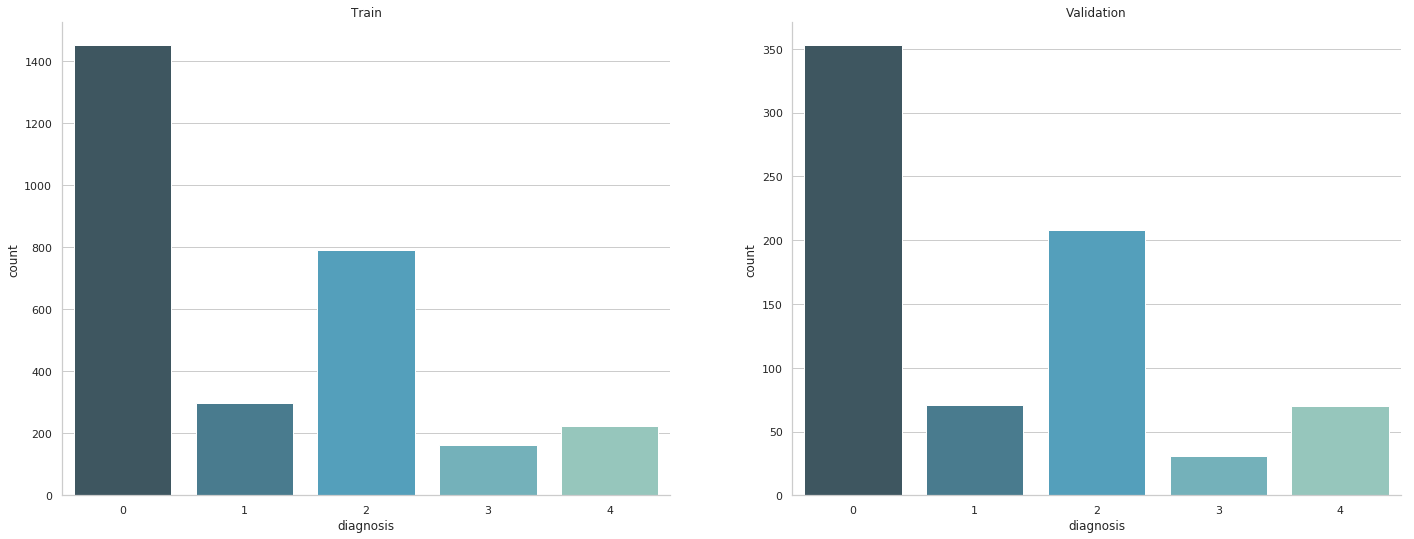

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=train, palette="GnBu_d", ax=ax1).set_title('Train')
sns.countplot(x="diagnosis", data=validation, palette="GnBu_d", ax=ax2).set_title('Validation')
sns.despine()
plt.show()

# Meta distribution

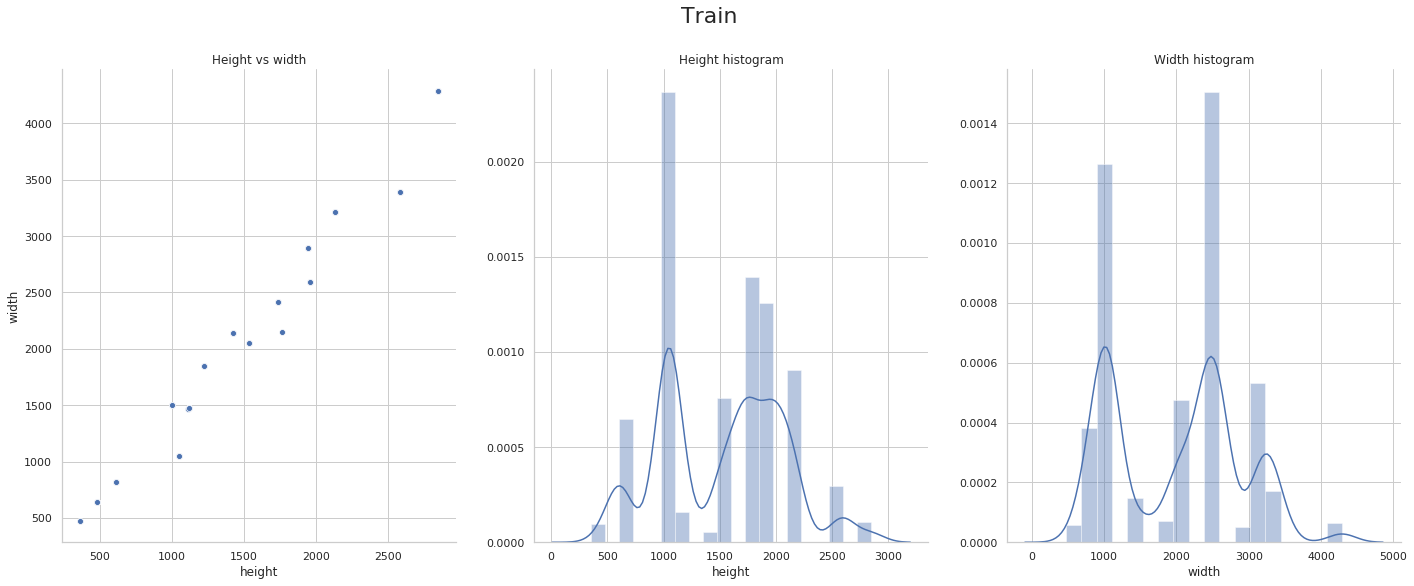

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(24, 8.7))
fig.suptitle('Train', fontsize=22)
sns.scatterplot(x="height", y="width", data=train, ax=ax1).set_title('Height vs width')
sns.distplot(train['height'], ax=ax2).set_title('Height histogram')
sns.distplot(train['width'], ax=ax3).set_title('Width histogram')
sns.despine()
plt.show()

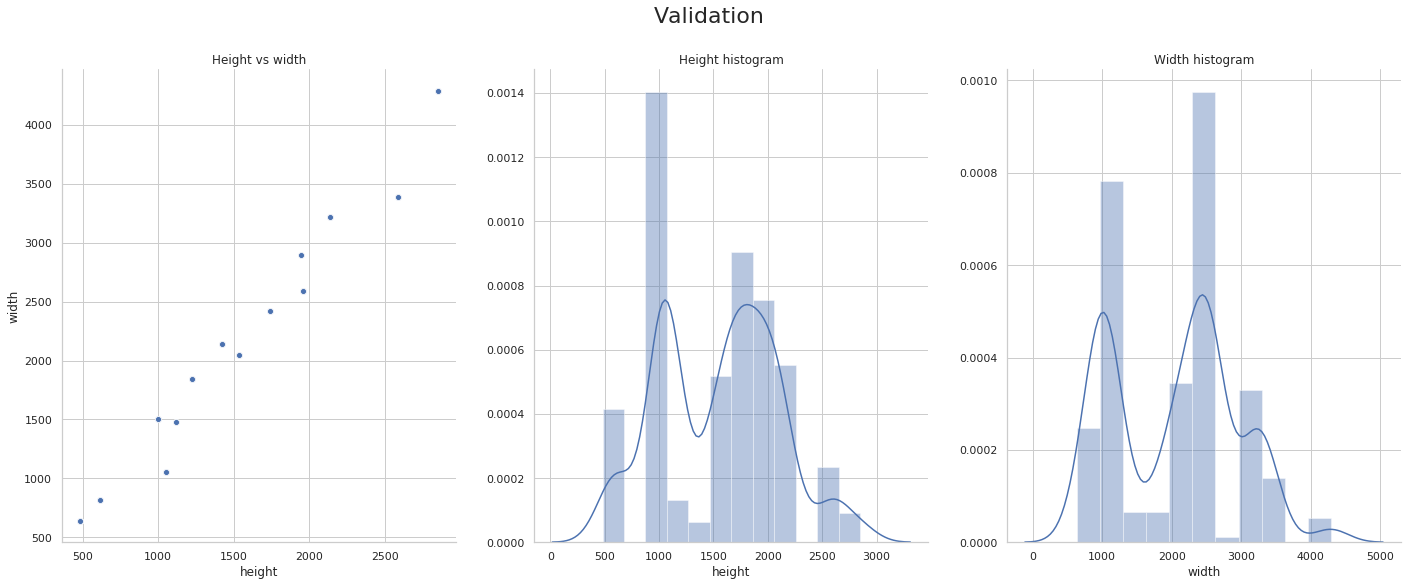

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(24, 8.7))
fig.suptitle('Validation', fontsize=22)
sns.scatterplot(x="height", y="width", data=validation, ax=ax1).set_title('Height vs width')
sns.distplot(validation['height'], ax=ax2).set_title('Height histogram')
sns.distplot(validation['width'], ax=ax3).set_title('Width histogram')
sns.despine()
plt.show()

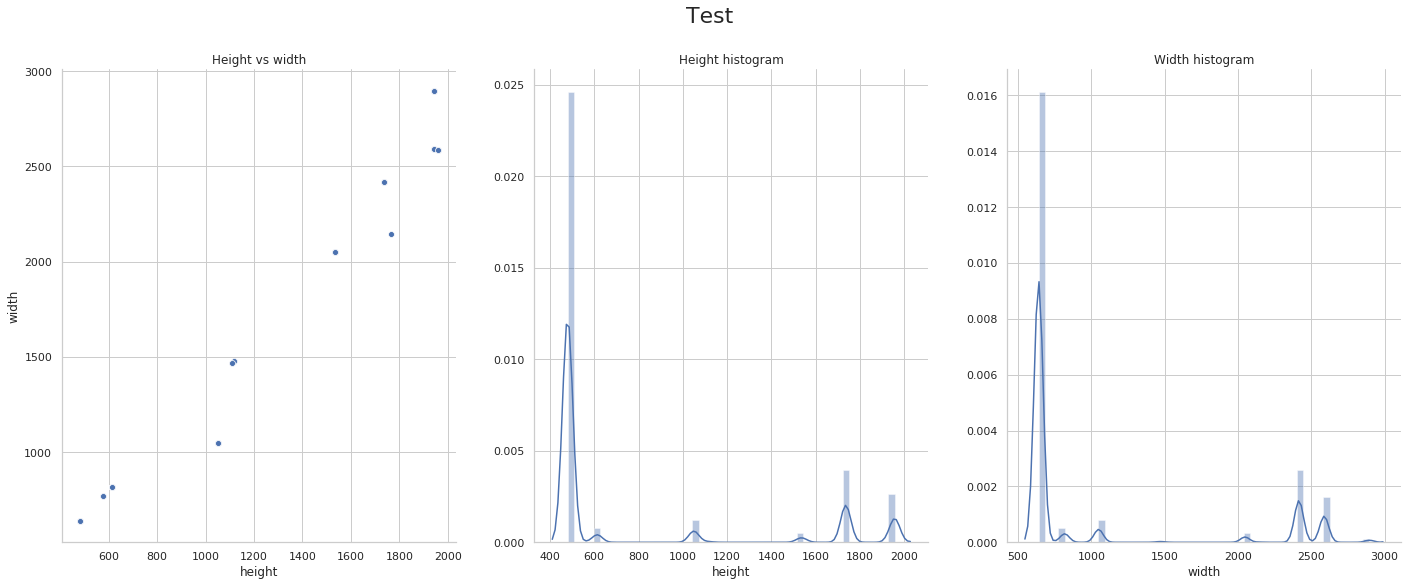

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(24, 8.7))
fig.suptitle('Test', fontsize=22)
sns.scatterplot(x="height", y="width", data=test_df, ax=ax1).set_title('Height vs width')
sns.distplot(test_df['height'], ax=ax2).set_title('Height histogram')
sns.distplot(test_df['width'], ax=ax3).set_title('Width histogram')
sns.despine()
plt.show()

# Output hold-out set

In [9]:
train['set'] = 'train'
validation['set'] = 'validation'
train_complete = train.append(validation)
train_complete.head()
train_complete.to_csv('hold-out.csv', index=False)
train_complete.head()

,id_code,diagnosis,height,width,set
1236,55eac26bd383,1,1736,2416,train
962,44e0d56e9d42,2,2136,3216,train
2447,aa4407aab872,0,1050,1050,train
2991,cffc50047828,0,614,819,train
2559,b0f0fa677d5f,0,1050,1050,train


# 5-Fold split

In [10]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for fold_n, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df['diagnosis'])):
    print('Fold: %s, Train size: %s, Validation size %s' % 
          (fold_n, len(trn_idx), len(val_idx)))
    train_df[('fold_%s' % fold_n)] = 0
    train_df[('fold_%s' % fold_n)].loc[trn_idx] = 'train'
    train_df[('fold_%s' % fold_n)].loc[val_idx] = 'validation'
    
display(train_df.head())

Fold: 0, Train size: 2929, Validation size 733
Fold: 1, Train size: 2929, Validation size 733
Fold: 2, Train size: 2929, Validation size 733
Fold: 3, Train size: 2930, Validation size 732
Fold: 4, Train size: 2931, Validation size 731


,id_code,diagnosis,height,width,fold_0,fold_1,fold_2,fold_3,fold_4
0,000c1434d8d7,2,2136,3216,train,train,train,train,validation
1,001639a390f0,4,2136,3216,train,train,validation,train,train
2,0024cdab0c1e,1,1736,2416,train,train,train,train,validation
3,002c21358ce6,0,1050,1050,train,train,train,validation,train
4,005b95c28852,0,1536,2048,train,validation,train,train,train


# Train & Validation label distribution

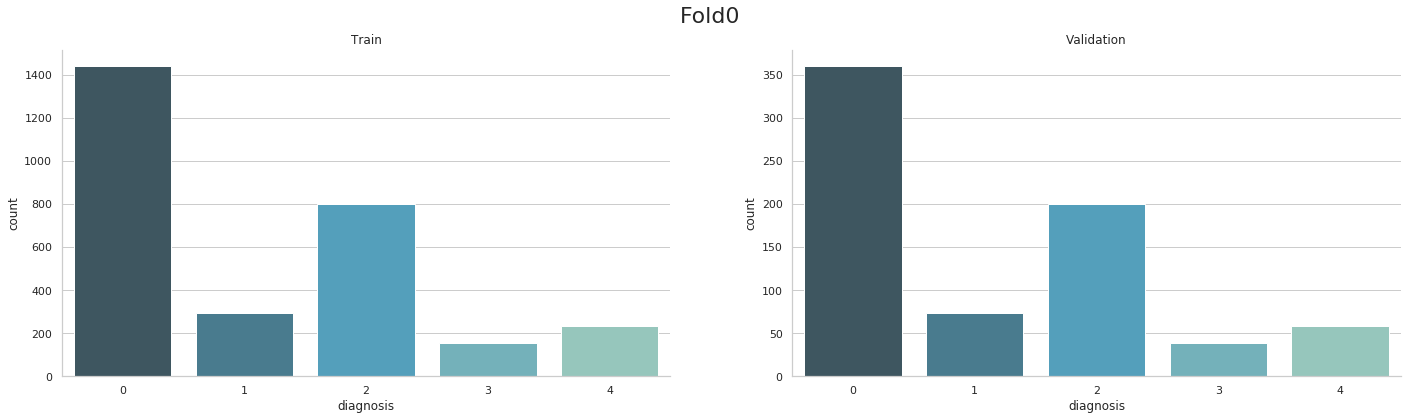

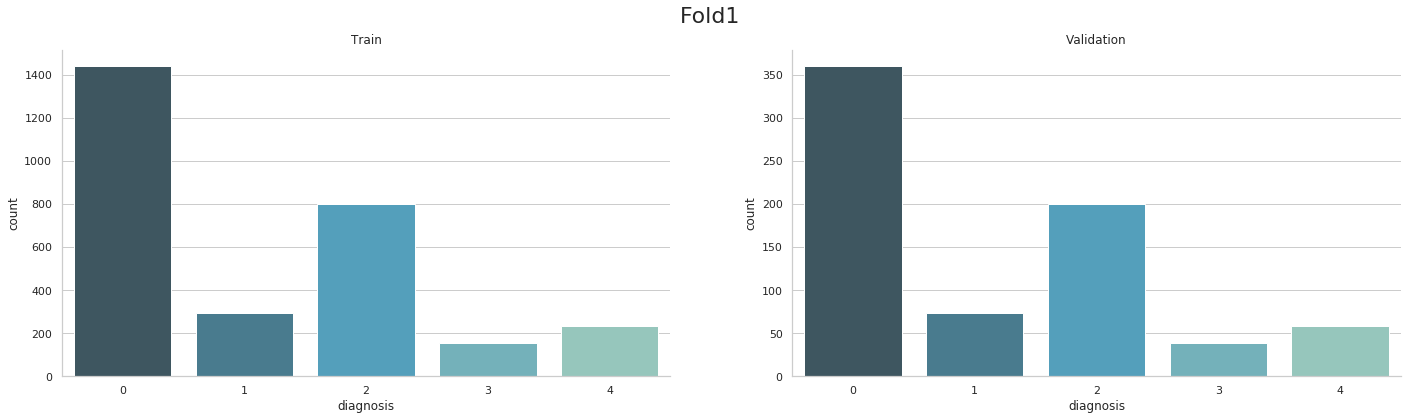

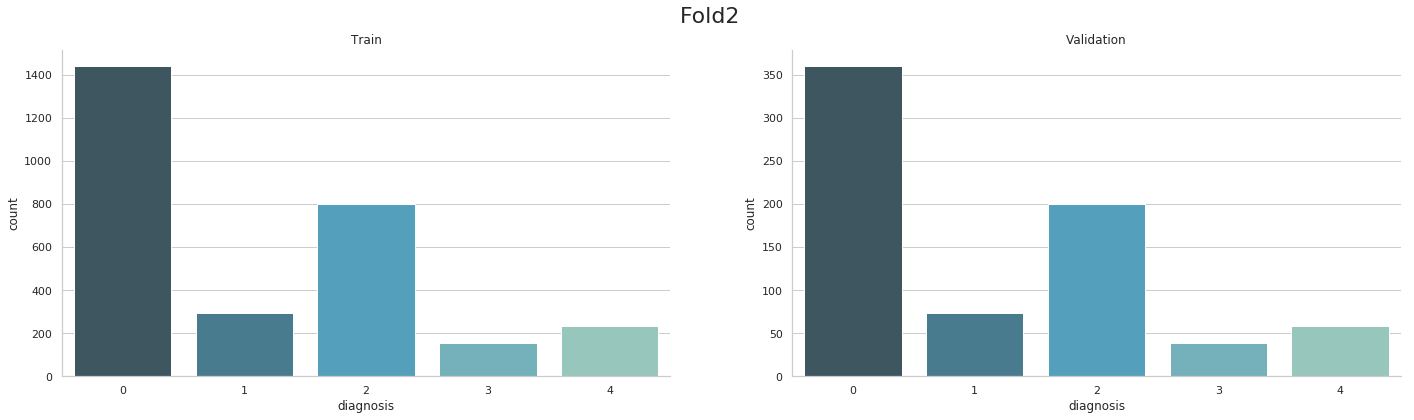

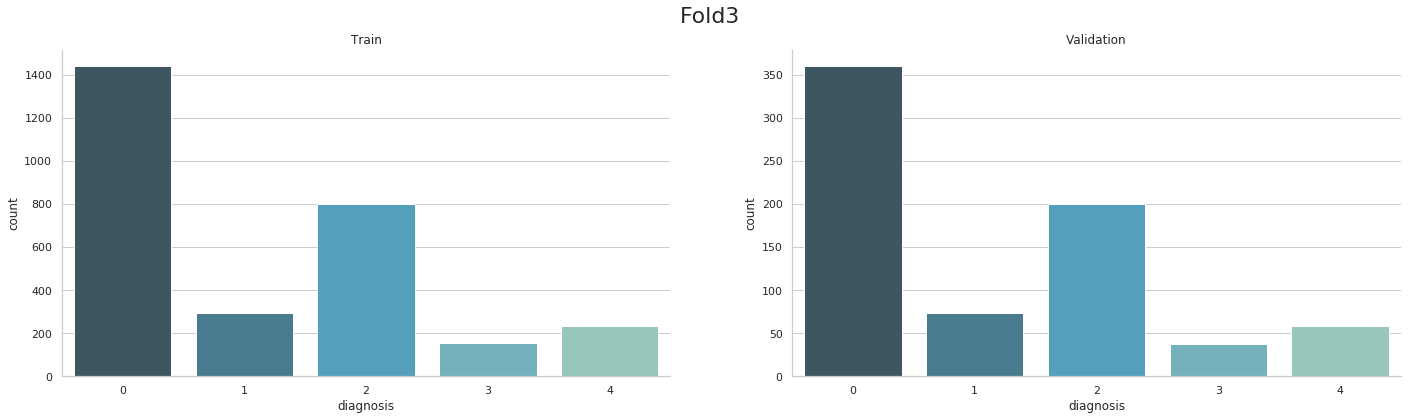

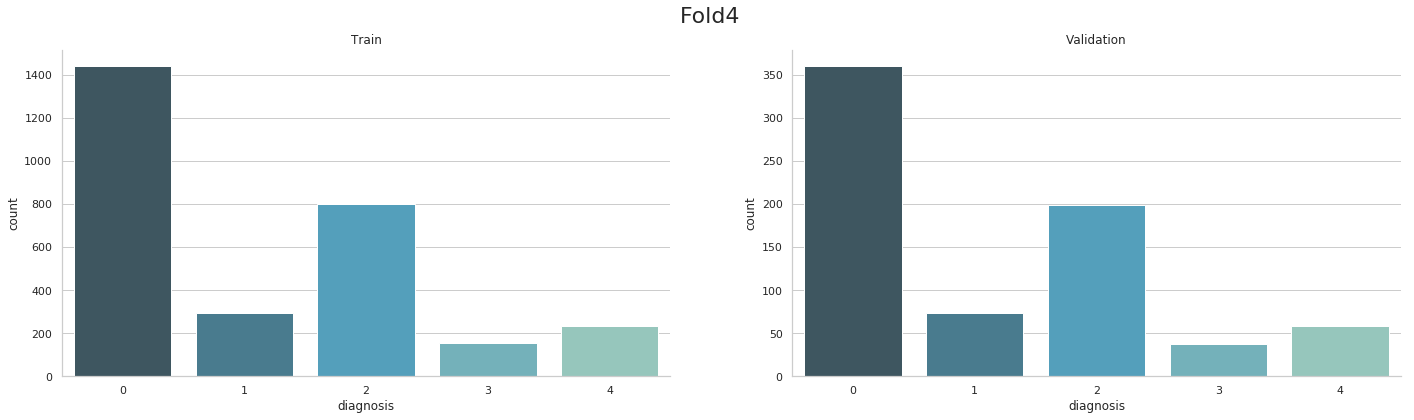

In [11]:
for fold_n, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df['diagnosis'])):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 6))
    fig.suptitle('Fold%s'%fold_n, fontsize=22)    
    sns.countplot(x="diagnosis", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="diagnosis", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

# Meta distribution

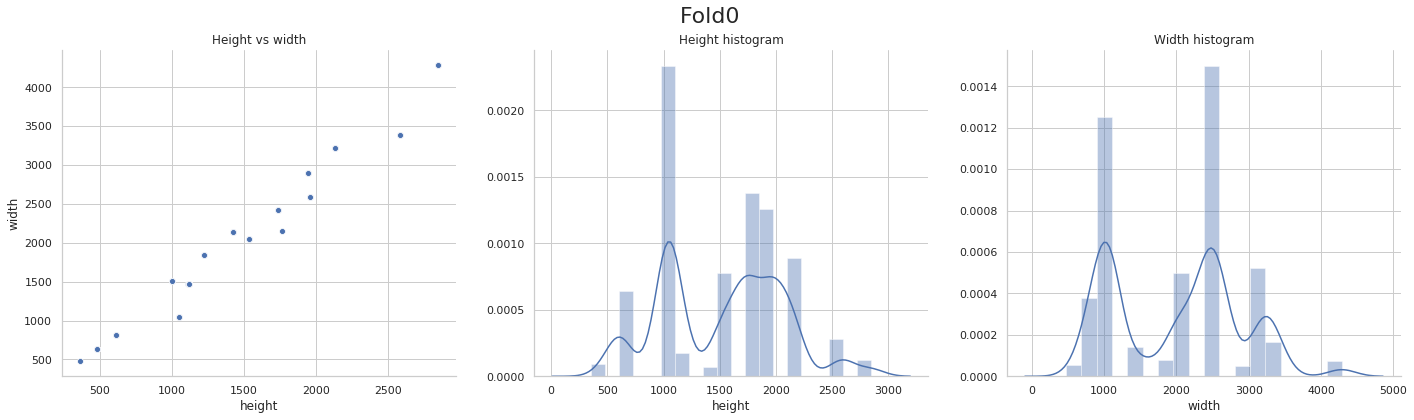

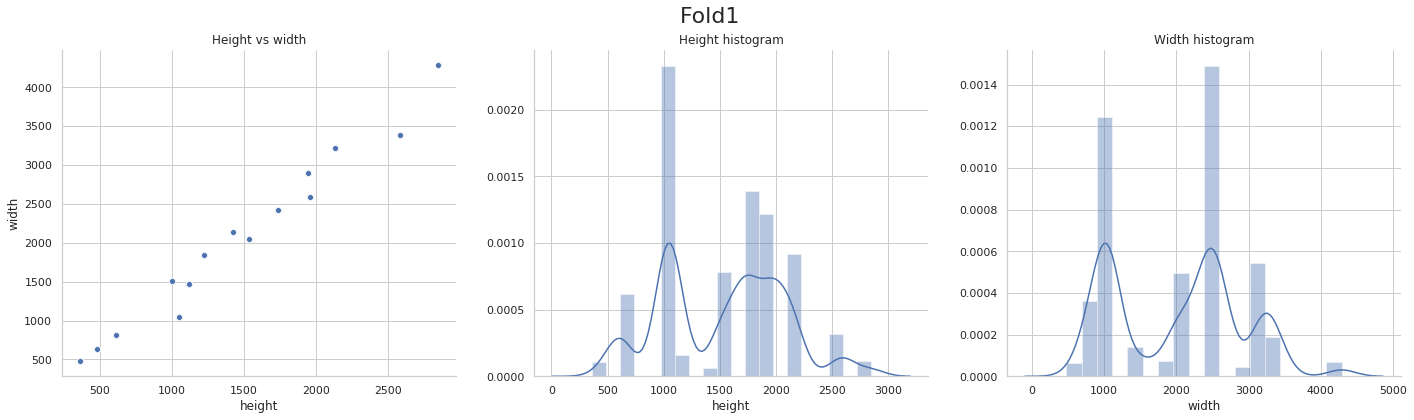

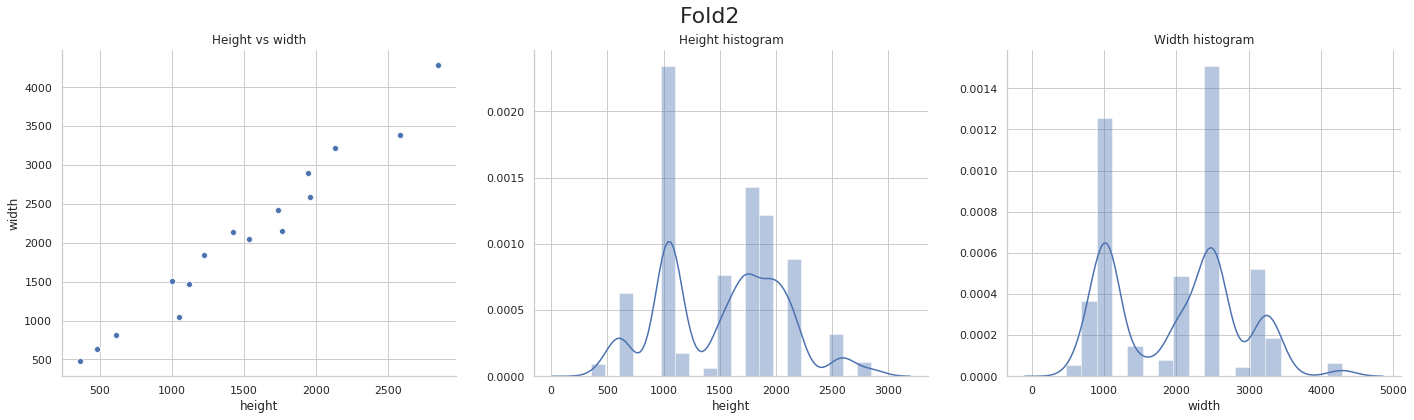

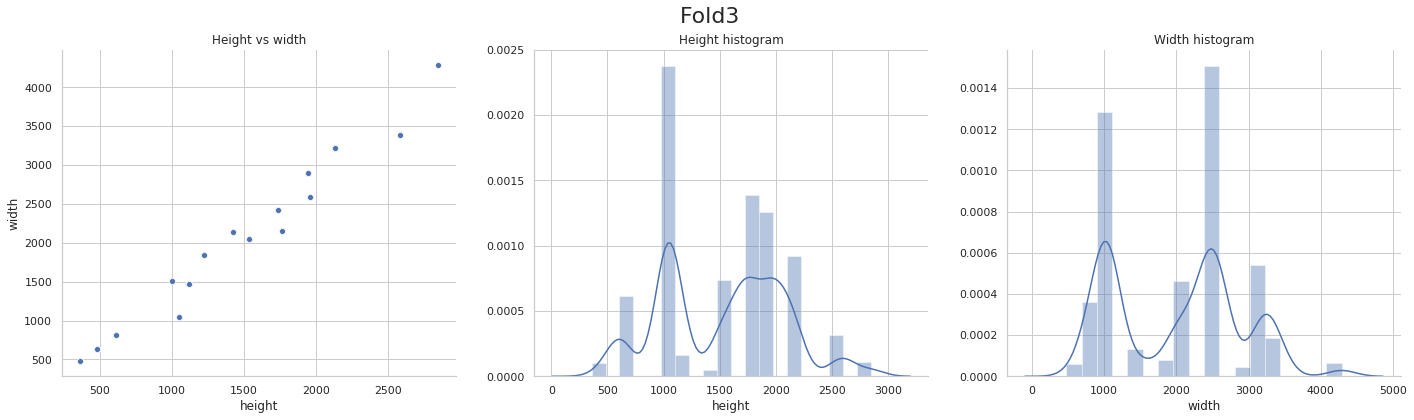

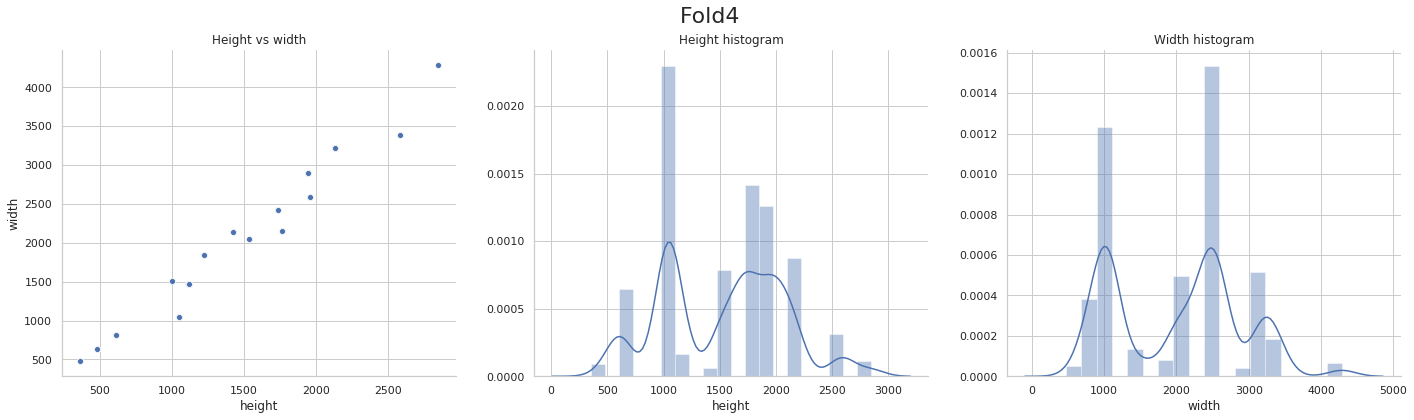

In [12]:
for fold_n, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df['diagnosis'])):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(24, 6))
    fig.suptitle('Fold%s'%fold_n, fontsize=22)    
    sns.scatterplot(x="height", y="width", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], ax=ax1).set_title('Height vs width')
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'train']['height'], ax=ax2).set_title('Height histogram')
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'train']['width'], ax=ax3).set_title('Width histogram')
    sns.despine()
    plt.show()

# Output 5-fold set

In [13]:
train_df.to_csv('5-fold.csv', index=False)
train_df.head()

,id_code,diagnosis,height,width,fold_0,fold_1,fold_2,fold_3,fold_4
0,000c1434d8d7,2,2136,3216,train,train,train,train,validation
1,001639a390f0,4,2136,3216,train,train,validation,train,train
2,0024cdab0c1e,1,1736,2416,train,train,train,train,validation
3,002c21358ce6,0,1050,1050,train,train,train,validation,train
4,005b95c28852,0,1536,2048,train,validation,train,train,train
